In [128]:
import pandas as pd
import numpy as np
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.forecasting.base import ForecastingHorizon

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

from sktime.forecasting.compose import ForecastingPipeline, make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.date import DateTimeFeatures

from sktime.forecasting.naive import NaiveForecaster
from sktime.datasets import load_longley

### Feature Engineering on the exogenous features (X)

In [129]:
kwargs = {
        "lag_feature": {
            "lag": [1],
            "mean": [[1, 3], [3, 6]],
            "std": [[1, 4]],
        }
    }

y_ll, X_ll = load_longley()
y_train_ll, y_test_ll, X_train_ll, X_test_ll = temporal_train_test_split(y_ll, X_ll, test_size=0.25)
fh = ForecastingHorizon(X_test_ll.index, is_relative=False)
# Example transforming only X
pipe = ForecastingPipeline(
    steps=[
        ("a", WindowSummarizer(n_jobs=1, target_cols=["POP", "GNPDEFL"])),
        ("b", WindowSummarizer(n_jobs=1, target_cols=["GNP"], **kwargs)),
        ("forecaster", NaiveForecaster(strategy="drift")),
    ]
)
pipe_return = pipe.fit(y_train_ll, X_train_ll)
y_pred1 = pipe_return.predict(fh=fh, X=X_test_ll)
display(y_pred1)

Period
1959    67075.727273
1960    67638.454545
1961    68201.181818
1962    68763.909091
Freq: A-DEC, Name: TOTEMP, dtype: float64

### Feature Engineering on the original ts (y) selfmade

MAPE selfmade:4.49 %
MAPE pipe:8.26 %


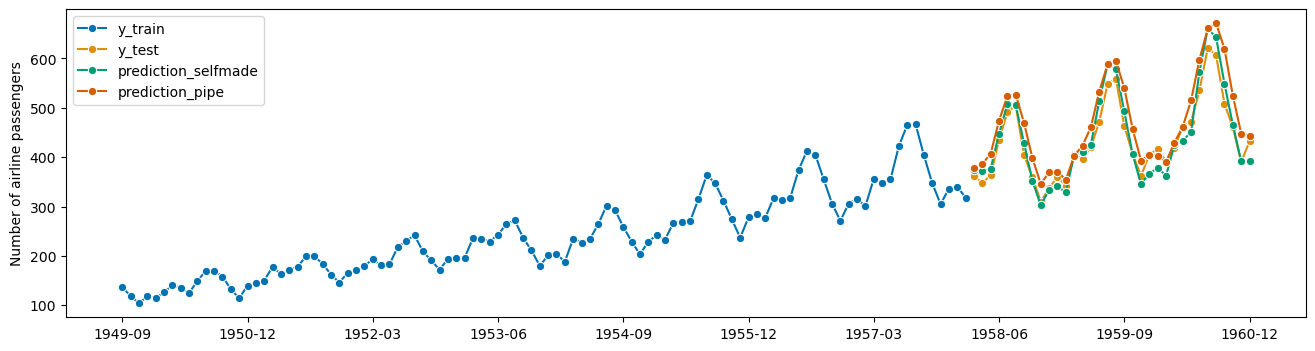

In [130]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error

from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import RecursiveTabularRegressionForecaster
from sktime.transformations.compose import YtoX, Id


# import warnings
# warnings.filterwarnings("ignore")

y = load_airline()

kwargs = {
        "lag_feature": {
            "lag": [1],
            "mean": [[1, 3], [3, 6]],
            "std": [[1, 4]],
        }
    }

window_features_y = WindowSummarizer(**kwargs).fit_transform(y)
date_features_y = DateTimeFeatures(ts_freq="M", feature_scope="minimal").fit_transform(y)
df = window_features_y.merge(date_features_y, how='inner',right_index=True,left_index=True).dropna()

y_train, y_test = temporal_train_test_split(y[df.index])
X_train, X_test  = temporal_train_test_split(df)

fh = ForecastingHorizon(y_test.index, is_relative=False)
f = RecursiveTabularRegressionForecaster(estimator=Ridge(random_state=42),window_length=12).fit(y_train, X=X_train)
f2 = RecursiveTabularRegressionForecaster(estimator=Ridge(random_state=42),window_length=12)

pipe = ForecastingPipeline(
        steps=[
            ("ytox", Id()+YtoX()), 
            ("summarizer", WindowSummarizer(**kwargs)),
            ("datetimefeat",DateTimeFeatures(ts_freq="M", feature_scope="minimal")),
            ("forecaster", f2),
        ]
    )

pipe.fit(y_train)
prediction_pipe=pipe.predict(fh=fh)
prediction_selfmade = f.predict(fh=fh,X=X_test)

plot_series(y_train,y_test,prediction_selfmade,prediction_pipe,labels=["y_train", "y_test","prediction_selfmade","prediction_pipe"])

print(f"MAPE selfmade:{round(mean_absolute_percentage_error(y_test, prediction_selfmade)*100,2)} %")
print(f"MAPE pipe:{round(mean_absolute_percentage_error(y_test, prediction_pipe)*100,2)} %")

